In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image

import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split

In [34]:
train_csv = pd.read_csv("train-metadata.csv")

/var/folders/tk/gjqscy953w90qhs86864yqf00000gn/T/ipykernel_6585/1863284004.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_csv = pd.read_csv("train-metadata.csv")


In [36]:
train_csv['target'].value_counts()

target
0    400666
1       393
Name: count, dtype: int64

In [37]:
train_csv.groupby(['sex','target']).size()

sex     target
female  0         123887
        1            109
male    0         265272
        1            274
dtype: int64

In [38]:
train_csv.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [39]:
img_dir = 'train-image/image/'
data_frame=train_csv
idx=0

In [40]:
img_name = os.path.join(img_dir,data_frame.isic_id[idx])
img_name = img_name + '.jpg'
img_name

'train-image/image/ISIC_0015670.jpg'

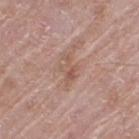

In [41]:
image = Image.open(img_name).convert('RGB')
image

In [42]:
image.size

(139, 139)

In [43]:
label = data_frame.target[idx]
label

np.int64(0)

In [44]:

class SkinCancerDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir,self.data_frame.isic_id[idx])
        img_name = img_name + '.jpg'
        
        image = Image.open(img_name).convert('RGB')
        
        label = self.data_frame.target[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label



In [70]:
# Define the transform to preprocess the images
transform = transforms.Compose([
    # transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# File paths
csv_file_path = 'train-metadata.csv'
image_file_path = 'train-image/image/'

# Load the dataset
full_dataset = SkinCancerDataset(csv_file_path, image_file_path, transform=transform)

# Split the dataset into training and validation sets
train_indices, val_indices = train_test_split(range(len(full_dataset)), test_size=0.2, stratify=full_dataset.data_frame.target)

train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
val_dataset = torch.utils.data.Subset(full_dataset, val_indices)




/var/folders/tk/gjqscy953w90qhs86864yqf00000gn/T/ipykernel_6585/748564202.py:3: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data_frame = pd.read_csv(csv_file)


In [71]:
# Calculate class weights for imbalanced data
labels = full_dataset.data_frame.iloc[:, 1].values
class_counts = pd.Series(labels).value_counts().sort_index()
class_weights = 1. / class_counts
samples_weights = [class_weights[label] for label in labels]


In [75]:
class_counts

0    400666
1       393
Name: count, dtype: int64

In [74]:
class_weights

0    0.000002
1    0.002545
Name: count, dtype: float64

In [76]:
samples_weights

[np.float64(2.4958444190422947e-06),
 np.float64(2.4958444190422947e-06),
 np.float64(2.4958444190422947e-06),
 np.float64(2.4958444190422947e-06),
 np.float64(2.4958444190422947e-06),
 np.float64(2.4958444190422947e-06),
 np.float64(2.4958444190422947e-06),
 np.float64(2.4958444190422947e-06),
 np.float64(2.4958444190422947e-06),
 np.float64(2.4958444190422947e-06),
 np.float64(2.4958444190422947e-06),
 np.float64(2.4958444190422947e-06),
 np.float64(2.4958444190422947e-06),
 np.float64(2.4958444190422947e-06),
 np.float64(2.4958444190422947e-06),
 np.float64(2.4958444190422947e-06),
 np.float64(2.4958444190422947e-06),
 np.float64(2.4958444190422947e-06),
 np.float64(2.4958444190422947e-06),
 np.float64(2.4958444190422947e-06),
 np.float64(2.4958444190422947e-06),
 np.float64(2.4958444190422947e-06),
 np.float64(2.4958444190422947e-06),
 np.float64(2.4958444190422947e-06),
 np.float64(2.4958444190422947e-06),
 np.float64(2.4958444190422947e-06),
 np.float64(2.4958444190422947e-06),
 

In [77]:
train_indices

[326666,
 192686,
 153390,
 211472,
 299804,
 294696,
 217845,
 106148,
 338651,
 5027,
 258893,
 44303,
 207965,
 328860,
 257722,
 17796,
 222388,
 352799,
 132701,
 249678,
 215436,
 400567,
 123222,
 295198,
 30905,
 40803,
 347647,
 152157,
 99805,
 183949,
 130851,
 59011,
 343348,
 14064,
 357919,
 106267,
 359895,
 55968,
 397544,
 378988,
 117787,
 243409,
 168035,
 219587,
 307349,
 194990,
 313837,
 359386,
 270936,
 8229,
 264064,
 50549,
 316240,
 147117,
 252557,
 266256,
 339516,
 210230,
 98801,
 231280,
 357641,
 164213,
 70059,
 257522,
 245284,
 265926,
 90276,
 146710,
 121349,
 4954,
 206319,
 13581,
 210413,
 155604,
 13027,
 53210,
 252901,
 30828,
 282334,
 283298,
 158373,
 304976,
 396709,
 233670,
 22409,
 272786,
 267238,
 125417,
 328027,
 319170,
 305033,
 318756,
 280773,
 205692,
 294715,
 46115,
 369873,
 352743,
 74797,
 281238,
 289997,
 154530,
 294996,
 293058,
 4360,
 393689,
 375913,
 107023,
 114854,
 45740,
 192700,
 79883,
 271897,
 111708,
 11

In [72]:
# Create a sampler for the training set
sampler = WeightedRandomSampler(samples_weights, num_samples=len(train_indices), replacement=True)

# Create the DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)



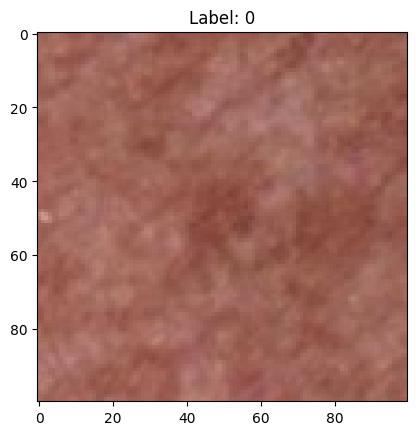

Image size: (100, 100, 3)


In [48]:
# Extract a sample image and label from the train_dataset
sample_image, sample_label = train_dataset[2]

# Check if the image is a tensor and convert it to a numpy array
if isinstance(sample_image, torch.Tensor):
    sample_image = sample_image.numpy().transpose(1, 2, 0)  # Convert CHW to HWC

# Display the sample image using matplotlib
plt.imshow((sample_image * 0.5) + 0.5)  # Unnormalize the image for display
plt.title(f"Label: {sample_label}")
plt.show()

# Print the size of the image
print(f"Image size: {sample_image.shape}")

In [49]:
# Define the model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(100*100*3, 128)  # Adjust based on your image size and channels
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.view(-1, 100*100*3)  # Flatten the image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Set device to MPS
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Instantiate the model, loss function, and optimizer
model = SimpleNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)





In [50]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'SkinCancerDataset' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>


KeyboardInterrupt: 

In [ ]:
# Define the training loop
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

In [ ]:
# Define the validation loop
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader.dataset)
    accuracy = correct / total
    return val_loss, accuracy

In [ ]:
# Main training procedure
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, accuracy = validate_model(model, val_loader, criterion, device)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

print('Training complete.')

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'SkinCancerDataset' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>


KeyboardInterrupt: 

In [51]:
len(val_dataset)

80212

In [52]:
image, label = val_dataset[0]

In [54]:
image.size()

torch.Size([3, 100, 100])

In [57]:
image.size()[1]

100

In [67]:
train_dataset

In [73]:
val_iter = iter(val_dataset)
count = 0
width_sum =0
height_sum = 0
for image, label in val_iter:

    width = image.size()[1]
    width_sum = width_sum + width

    height = image.size()[2]
    height_sum = height_sum + height

    count = count + 1

    print(count, f"image width {width} and height {height}")



1 image width 99 and height 99
2 image width 141 and height 141
3 image width 131 and height 131
4 image width 139 and height 139
5 image width 137 and height 137
6 image width 129 and height 129
7 image width 135 and height 135
8 image width 133 and height 133
9 image width 133 and height 133
10 image width 123 and height 123
11 image width 145 and height 145
12 image width 111 and height 111
13 image width 147 and height 147
14 image width 147 and height 147
15 image width 131 and height 131
16 image width 137 and height 137
17 image width 115 and height 115
18 image width 121 and height 121
19 image width 127 and height 127
20 image width 99 and height 99
21 image width 131 and height 131
22 image width 115 and height 115
23 image width 129 and height 129
24 image width 131 and height 131
25 image width 129 and height 129
26 image width 177 and height 177
27 image width 139 and height 139
28 image width 127 and height 127
29 image width 93 and height 93
30 image width 129 and height

In [78]:
avg_width = width_sum/count
avg_height = height_sum/count

In [79]:
avg_height

133.22834488605196

In [82]:
avg_width

133.22834488605196

In [88]:
val_iter = iter(val_dataset)
count = 0
width_list =[]
height_list = []
for image, label in val_iter:

    width = image.size()[1]
    width_list += [width]

    height = image.size()[2]
    height_list.append(height)

    count = count + 1

    print(count, f"image width {width} and height {height}")


TypeError: 'int' object is not iterable

In [87]:
from statistics import median
med = median(width_list)
print(med)  # Output: 3

131.0
